## Bibliotecas

In [258]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R
from sklearn.cluster import DBSCAN,AgglomerativeClustering
from sklearn.metrics import silhouette_score,silhouette_samples
from joblib import dump, load

# Limpieza de archivos

In [3]:
info1 = pd.read_csv('../data/info_01.csv')

In [4]:
info1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17286 entries, 0 to 17285
Data columns (total 5 columns):
id     17286 non-null int64
id2    17286 non-null int64
v4     17286 non-null float64
v5     17286 non-null float64
v6     17286 non-null float64
dtypes: float64(3), int64(2)
memory usage: 675.4 KB


In [6]:
info1.describe()

,id,id2,v4,v5,v6
count,17286.000000,17286.000000,17286.000000,17286.000000,17286.000000
mean,4075.651047,4075.651047,606.032176,25.730504,0.003862
std,2347.052912,2347.052912,313.824105,5.527639,0.000851
min,1.000000,1.000000,412.800000,16.700000,0.002674
25%,2042.250000,2042.250000,439.000000,20.200000,0.003080
50%,4086.000000,4086.000000,453.500000,26.200000,0.003800
75%,6102.750000,6102.750000,637.500000,30.500000,0.004351
max,8143.000000,8143.000000,2028.500000,39.100000,0.006476


In [8]:
info1.head()

,id,id2,v4,v5,v6
0,1,1,721.2,27.3,0.004793
1,1,1,721.2,27.3,0.004793
2,2,2,714.0,27.3,0.004783
3,2,2,714.0,27.3,0.004783
4,3,3,713.5,27.2,0.004779


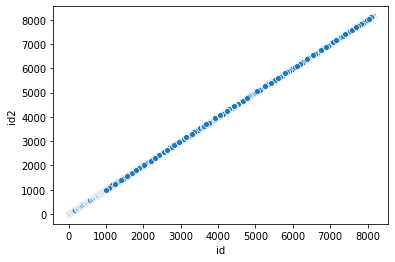

In [9]:
sn.scatterplot(x='id',y='id2',data=info1)

El dataset no tiene elementos nulos, pero id y id2 son los mismos datos por lo que se puede eliminar id2 sin afectar los datos.

In [11]:
info1.drop('id2',axis=1,inplace=True)

Para encontrar datos repetidos los ordenare por id y utilizaré el método duplicates en las demás columnas para verificar si el id y los datos de v5, v5, v6 están repetidos

In [12]:
info1 = info1.sort_values(by=['id'])
info1.duplicated(info1.columns[~info1.columns.isin(['id'])])

0        False
1         True
2        False
3         True
4        False
         ...  
16281     True
16282    False
16283     True
16284    False
16285     True
Length: 17286, dtype: bool

Existen datos repetidos por lo que procederé a eliminarlos

In [13]:
info1 = info1.drop_duplicates(info1.columns[~info1.columns.isin(['id'])],keep='first')

In [15]:
info1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7236 entries, 0 to 16284
Data columns (total 4 columns):
id    7236 non-null int64
v4    7236 non-null float64
v5    7236 non-null float64
v6    7236 non-null float64
dtypes: float64(3), int64(1)
memory usage: 282.7 KB


Nos quedan 7236 registros limpios, ninguno de ellos nulos

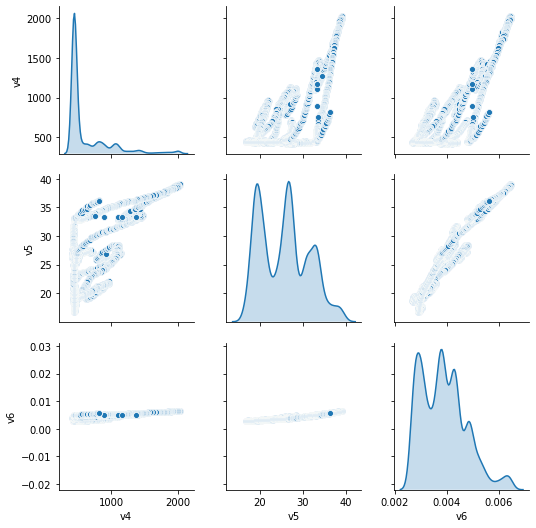

In [20]:
sn.pairplot(info1, vars=["v4", "v5","v6"],diag_kind="kde")

La columna no se utilizará para alimentar al modelo por lo que se puede eliminar del dataset

In [25]:
info1.drop('id',axis=1,inplace=True)

## Tratatamiento de los datos

In [26]:
info1.describe()

,v4,v5,v6
count,7236.000000,7236.000000,7236.000000
mean,625.649198,25.752073,0.003883
std,328.062581,5.566444,0.000861
min,412.800000,16.700000,0.002674
25%,439.500000,20.400000,0.003103
50%,456.000000,26.200000,0.003809
75%,714.075000,30.500000,0.004357
max,2028.500000,39.100000,0.006476


Con la información de media, máximo y mínimo de cada feature se puede ver que las escalas varian mucho por lo que sería conveniente "re escalar" los datos

In [28]:
scaler = StandardScaler()
scaler.fit(info1)
info1_scale = scaler.transform(info1)

In [35]:
plt.scatter(info1_scale[:,1],info1_scale[:,0])

array([[0.29127798, 0.27810108, 1.05707022],
       [0.26932943, 0.27810108, 1.04597549],
       [0.26780522, 0.26013504, 1.04135337],
       ...,
       [0.52692003, 1.85911195, 1.98982197],
       [0.59337536, 1.89504401, 2.0198159 ],
       [0.59550925, 1.87707798, 2.00890873]])

In [38]:
scaler.mean_

array([6.25649198e+02, 2.57520730e+01, 3.88335890e-03])

In [43]:
df_info1_scale = pd.DataFrame({'v4':info1_scale[:,0],'v5':info1_scale[:,1],'v6':info1_scale[:,2]})

In [44]:
df_info1_scale.describe()

,v4,v5,v6
count,7.236000e+03,7.236000e+03,7.236000e+03
mean,2.317414e-16,6.284513e-17,-3.456482e-16
std,1.000069e+00,1.000069e+00,1.000069e+00
min,-6.488515e-01,-1.626298e+00,-1.405235e+00
25%,-5.674590e-01,-9.615552e-01,-9.066997e-01
50%,-5.171602e-01,8.047472e-02,-8.697561e-02
75%,2.695581e-01,8.530141e-01,5.509732e-01
max,4.276464e+00,2.398093e+00,3.012895e+00


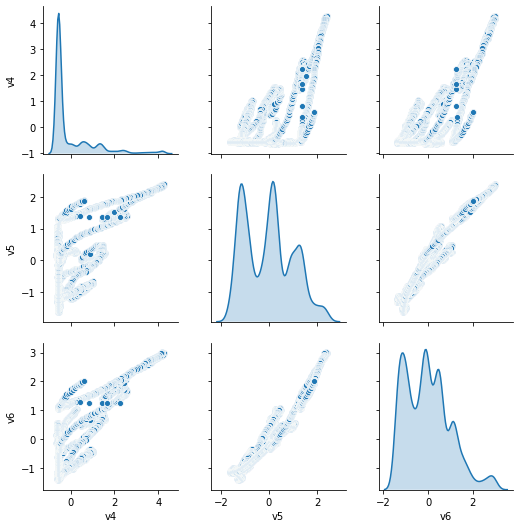

In [46]:
sn.pairplot(df_info1_scale,diag_kind="kde")

## KMeans

Para encontrar el número óptimo de clusters utilizo la técnica del codo o (The Elbow Method)

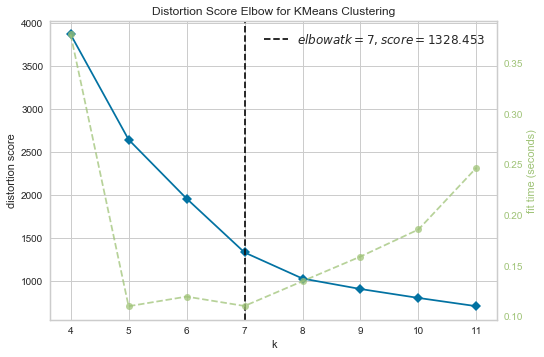

In [58]:
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(4,12))
visualizer.fit(df_info1_scale)
visualizer.poof();

Lo óptimo con este método es hacer 7 clústers, por lo que se parametrizará asi el modelo.

In [60]:
k_model = KMeans(n_clusters = 7)
k_model.fit(df_info1_scale)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [62]:
df_info1_scale['KMeans'] = k_model.labels_

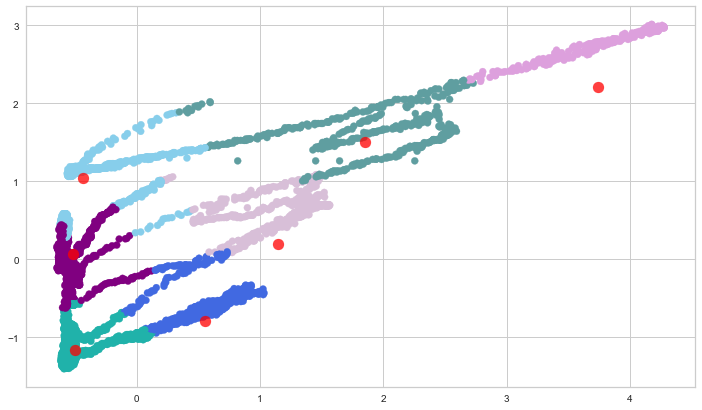

In [85]:
color = ['royalblue','skyblue','plum','lightseagreen','thistle','purple','cadetblue']
vectorizar = np.vectorize(lambda x: color[x % len(color)])

plt.figure(figsize=(12,7))
plt.scatter(df_info1_scale.v4, df_info1_scale.v6, c = vectorizar(df_info1_scale['KMeans']))

centers = k_model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=120, alpha=0.75)

plt.show();

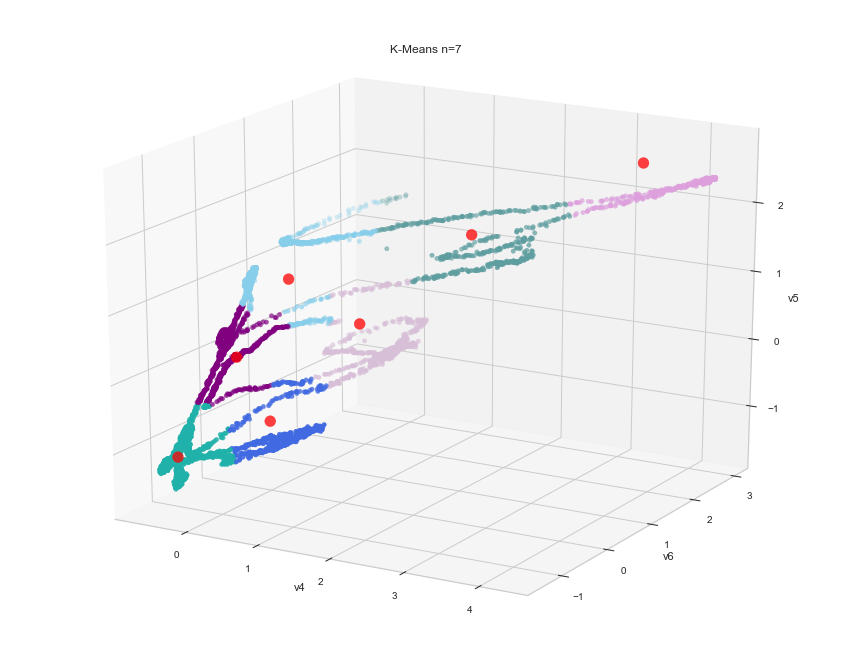

In [249]:
fig = plt.figure(figsize=(15, 12))
ax = fig.gca(projection='3d')
ax2 = fig.gca(projection='3d')
ax.scatter(df_info1_scale.v4, df_info1_scale.v6,df_info1_scale.v5, c = vectorizar(df_info1_scale['KMeans']))
ax.set_xlabel('v4')
ax.set_ylabel('v6')
ax.set_zlabel('v5')
ax2.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='red', s=120, alpha=0.75)
ax.view_init(elev=20)
ax2.view_init(elev=20)
ax.set_title('K-Means n=7')
plt.show();
fig.savefig('./Graficas/Resultados_KMeans.png');

In [160]:
score_km = silhouette_score(df_info1_scale[['v4','v5','v6']], df_info1_scale['KMeans'], metric='euclidean')
score_km

0.6044078380500512

## DBSCAN

In [203]:
X = df_info1_scale[['v4','v5','v6']]
dbscan = DBSCAN(eps=0.099)
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.099, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [204]:
df_info1_scale['DBSCAN'] = dbscan.labels_ 
labels = dbscan.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print('Número de clusters: %d' % n_clusters)
print('Número de puntos de ruido %d' % n_noise)

Número de clusters: 7
Número de puntos de ruido 15


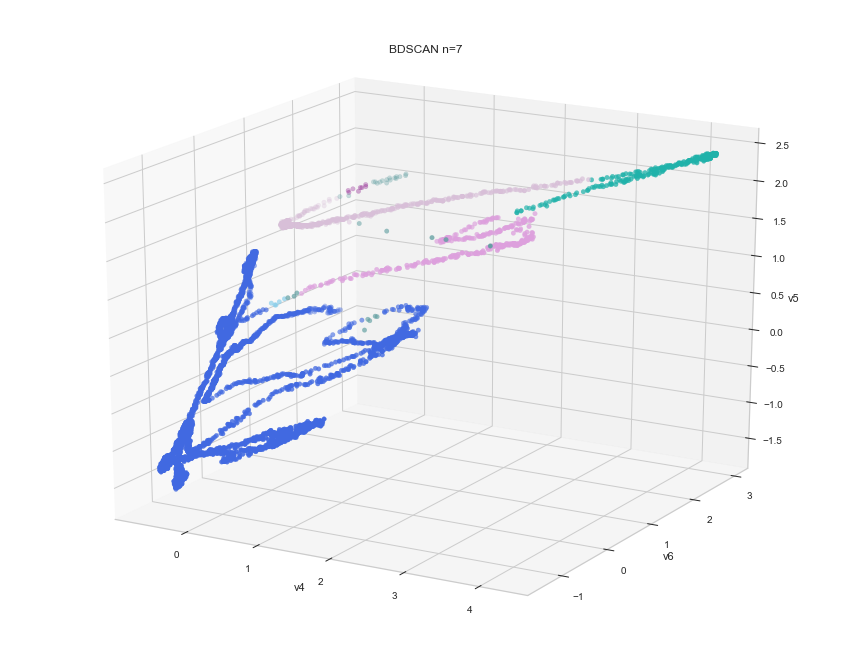

In [250]:
color = ['royalblue','skyblue','plum','lightseagreen','thistle','purple','cadetblue']
vectorizar = np.vectorize(lambda x: color[x % len(color)])

fig = plt.figure(figsize=(15, 12))
ax = fig.gca(projection='3d')
ax2 = fig.gca(projection='3d')
ax.scatter(df_info1_scale.v4, df_info1_scale.v6,df_info1_scale.v5, c = vectorizar(df_info1_scale['DBSCAN']))
ax.set_xlabel('v4')
ax.set_ylabel('v6')
ax.set_zlabel('v5')
ax.view_init(elev=20)
ax.set_title(f'BDSCAN n={n_clusters}')
plt.show();
fig.savefig('./Graficas/Resultados_DBSCAN.png')

In [209]:
score_DBSCAN = silhouette_score(df_info1_scale[['v4','v5','v6']], df_info1_scale.DBSCAN, metric='euclidean')
score_DBSCAN

-0.020240056293348373

## Agrupamiento Aglomerativo

In [240]:
X =  df_info1_scale[['v4','v5','v6']]
clusters = 7
ac = AgglomerativeClustering(n_clusters = clusters, affinity='euclidean', linkage ='complete')
ac.fit(X)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='complete', memory=None, n_clusters=7)

In [241]:
df_info1_scale['Aglo'] = ac.labels_

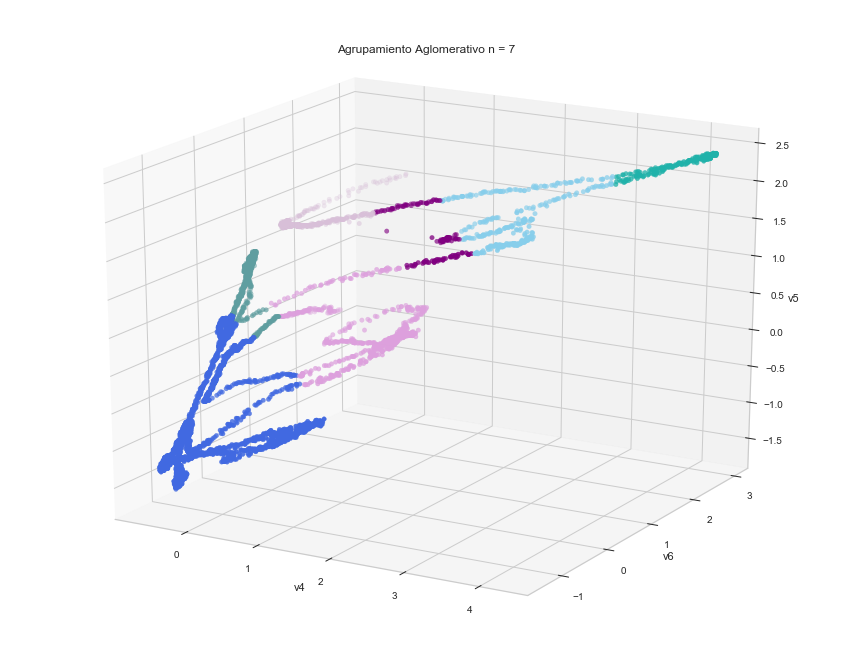

In [251]:
color = ['royalblue','skyblue','plum','lightseagreen','thistle','purple','cadetblue']
vectorizar = np.vectorize(lambda x: color[x % len(color)])

fig = plt.figure(figsize=(15, 12))
ax = fig.gca(projection='3d')
ax2 = fig.gca(projection='3d')
ax.scatter(df_info1_scale.v4, df_info1_scale.v6,df_info1_scale.v5, c = vectorizar(df_info1_scale['Aglo']))
ax.set_xlabel('v4')
ax.set_ylabel('v6')
ax.set_zlabel('v5')
ax.view_init(elev=20)
ax.set_title(f'Agrupamiento Aglomerativo n = {clusters}')
plt.show();
fig.savefig('./Graficas/Resultados_Agrupamiento.png')

In [243]:
score_ac = silhouette_score(df_info1_scale[['v4','v5','v6']], df_info1_scale['Aglo'], metric='euclidean')
score_ac

0.3832023161490804

## Análisis de silhouette score a los modelos anteriores

In [256]:
def plotSilhouetteScore(X,labels,modelo=''):
    cluster_labels = np.unique(labels)
    n_clusters = cluster_labels.shape[0]
    silouette_vals = silhouette_samples(X,labels,metric='euclidean')
    y_ax_lower,y_ax_upper = 0,0
    yticks=[]
    
    for i, c in enumerate(cluster_labels):
        c_sil_vals = silouette_vals[labels == c]
        c_sil_vals.sort()
        y_ax_upper += len(c_sil_vals)
        color = cm.jet(i / n_clusters)
        plt.barh(range(y_ax_lower,y_ax_upper),c_sil_vals,height = 1.0,edgecolor = 'none',color = color)
        yticks.append((y_ax_lower+y_ax_upper)/2)
        y_ax_lower += len(c_sil_vals)

    sil_avg = np.mean(silouette_vals)
    plt.axvline(sil_avg,color='red',linestyle='--')
    plt.yticks(yticks,cluster_labels+1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette score')
    plt.title(modelo)
    plt.show()
    #plt.savefig('./Graficas/' + modelo + '.png')

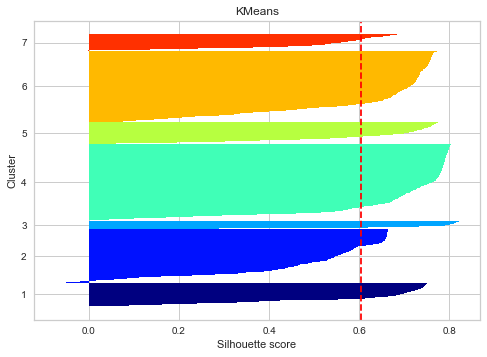

<Figure size 576x396 with 0 Axes>

In [257]:
plotSilhouetteScore(df_info1_scale[['v4','v5','v6']],df_info1_scale.KMeans,'KMeans')

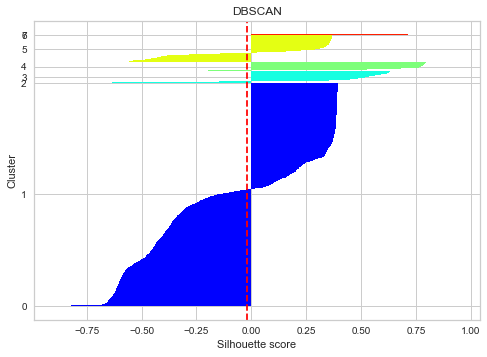

In [239]:
plotSilhouetteScore(df_info1_scale[['v4','v5','v6']],df_info1_scale.DBSCAN,'DBSCAN')

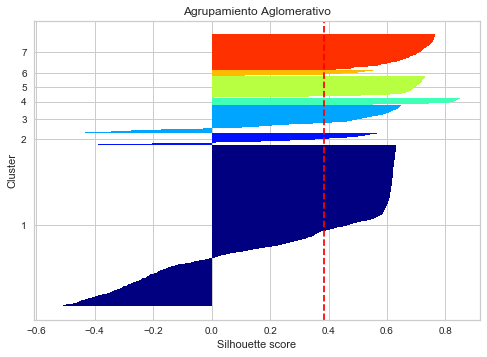

In [244]:
plotSilhouetteScore(df_info1_scale[['v4','v5','v6']],df_info1_scale.Aglo,'Agrupamiento Aglomerativo')

# Resultados

El mejor ajuste esta en el modelo K-Means con 7 clusters, el modelo DBSCAN tiene muchos datos en clusters erroneos y el modelo de agrupamiento aglomerativo presenta menos datos erroneos pero se puede observas que aún son vario los clusters con un silhouette score negativo por lo que no es buen modelo de clusterización para estos datos.

In [260]:
dump(kmeans, 'KMeans.joblib')

['KMeans.joblib']